In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import pandas as pd

c:\Users\wwwhh\OneDrive\Desktop\fyp backend\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
%run ../database.ipynb

In [6]:
df = pd.DataFrame(get_all_content())

In [7]:
model_name = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
sentiment_analysis = pipeline("sentiment-analysis", model=model_name, device=0)

In [5]:
def split_text(text, max_length=500):
    """Splits text into smaller chunks within the token limit."""
    tokens = tokenizer.encode(text, add_special_tokens=False)
    chunks = [tokens[i:i+max_length] for i in range(0, len(tokens), max_length)]
    return [tokenizer.decode(chunk, skip_special_tokens=True) for chunk in chunks]

def average_sentiment_score(text):
    """Computes sentiment score weighted by word count."""
    chunks = split_text(text)
    results = sentiment_analysis(chunks)

    sentiment_map = {"POSITIVE": 1, "NEGATIVE": -1}
    
    total_weighted_score = 0
    total_words = 0

    for chunk, result in zip(chunks, results):
        word_count = len(chunk.split())  # Count words in the chunk
        total_words += word_count
        total_weighted_score += sentiment_map[result['label']] * result['score'] * word_count

    sentiment_score = total_weighted_score / total_words if total_words != 0 else 0

    # Interpret final sentiment
    final_sentiment = "POSITIVE" if sentiment_score > 0 else "NEGATIVE"
    if abs(sentiment_score) < 0.1:  # Define threshold for neutral/mixed sentiment
        final_sentiment = "NEUTRAL"

    return {
        "final_sentiment": final_sentiment,
        "sentiment_score": sentiment_score
    }

In [6]:
for i in range(len(df)):
    try:
        # Convert row to dictionary
        temp_dict = dict(df.iloc[i].to_dict())

        # Skip if sentiment already exists
        if not pd.isna(temp_dict.get('sentiment')) and temp_dict.get("sentiment") is not None:
            continue

        # Calculate sentiment using the function
        sentiment = average_sentiment_score(temp_dict['preprocessed_text'])

        # Synchronize GPU after the sentiment analysis
        torch.cuda.synchronize()

        # Assign calculated sentiment values to dictionary
        temp_dict['siebert_sentiment_label'] = sentiment["final_sentiment"]
        temp_dict['siebert_sentiment_score'] = sentiment["sentiment_score"]

        # Update the content table in the database
        update_content_table(temp_dict)

    except Exception as e:
        print(f"Error processing row {i}: {e}")
        continue


Token indices sequence length is longer than the specified maximum sequence length for this model (1064 > 512). Running this sequence through the model will result in indexing errors


Updated document with ID: 671bb15ac146c0252b26a9c8
Updated document with ID: 671bb15bc146c0252b26a9ca
Updated document with ID: 671bb15cc146c0252b26a9cc
Updated document with ID: 671bb15dc146c0252b26a9ce


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Updated document with ID: 671bb15ec146c0252b26a9d0
Updated document with ID: 671bb15fc146c0252b26a9d2
Updated document with ID: 671bb160c146c0252b26a9d4
Updated document with ID: 671bb162c146c0252b26a9d6
Updated document with ID: 671bb163c146c0252b26a9d8
Updated document with ID: 671bb164c146c0252b26a9da
Updated document with ID: 671bb164c146c0252b26a9dc
Updated document with ID: 671bb165c146c0252b26a9de
Updated document with ID: 671bb166c146c0252b26a9e0
Updated document with ID: 671bb167c146c0252b26a9e2
Updated document with ID: 671bb168c146c0252b26a9e4
Updated document with ID: 671bb169c146c0252b26a9e6
Updated document with ID: 671bb16ac146c0252b26a9e8
Updated document with ID: 671bb16bc146c0252b26a9ea
Updated document with ID: 671bb16cc146c0252b26a9ec
Updated document with ID: 671bb16ec146c0252b26a9ee
Updated document with ID: 671bb16fc146c0252b26a9f0
Updated document with ID: 671bb16fc146c0252b26a9f2
Updated document with ID: 671bb170c146c0252b26a9f4
Updated document with ID: 671bb

In [8]:
sentiment_counts = df["siebert_sentiment_label"].value_counts()

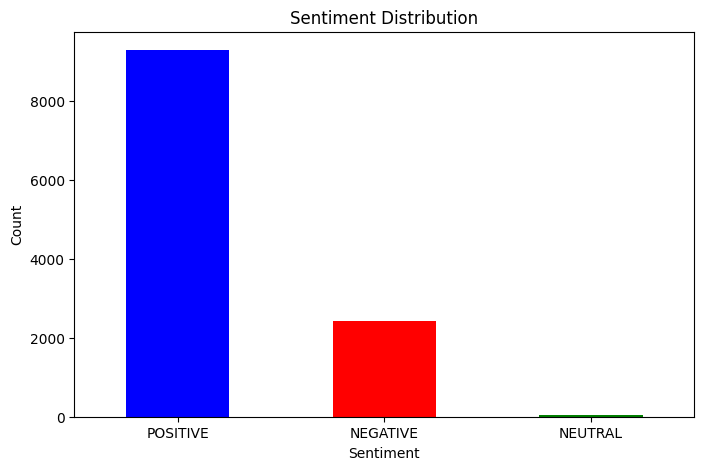

In [ ]:
import matplotlib.pyplot as plt

sentiment_counts = df["siebert_sentiment_label"].value_counts()

# Plot bar chart
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind="bar", color=["blue", "red", "green"])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution")
plt.xticks(rotation=0)
plt.show()

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
data = pd.DataFrame(get_all_content())
analyzer = SentimentIntensityAnalyzer()

# Apply VADER to preprocessed_text
data['vader_scores'] = data['preprocessed_text'].apply(lambda x: analyzer.polarity_scores(x))
data['compound'] = data['vader_scores'].apply(lambda x: x['compound'])  # -1 to 1
data['pos'] = data['vader_scores'].apply(lambda x: x['pos'])
data['neg'] = data['vader_scores'].apply(lambda x: x['neg'])
data['neu'] = data['vader_scores'].apply(lambda x: x['neu'])

# Group by search_keyword
vader_by_keyword = data.groupby('search_keyword')[['compound', 'pos', 'neg', 'neu']].mean()
print("VADER Sentiment by Search Keyword:")
print(vader_by_keyword)

# Visualization
vader_by_keyword[['pos', 'neg', 'neu']].plot(kind='bar', figsize=(12, 6), colormap='Pastel1')
plt.title("VADER Sentiment Components by Search Keyword")
plt.ylabel("Score")
plt.show()

NameError: name 'pd' is not defined

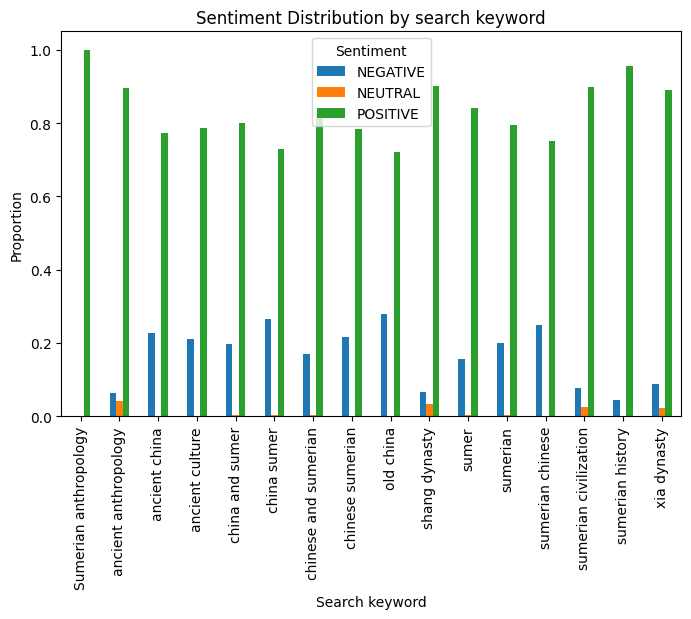

In [11]:
language_sentiment = df.groupby("search_keyword")["siebert_sentiment_label"].value_counts(normalize=True).unstack()

language_sentiment.plot(kind="bar", figsize=(8, 5))
plt.xlabel("Search keyword")
plt.ylabel("Proportion")
plt.title("Sentiment Distribution by search keyword")
plt.legend(title="Sentiment")
plt.show()